## Example application of the CILVA model to calcium imaging data from the larval zebrafish optic tectum

### Overview
This notebook demonstrates some of the functionality of the calcium imaging latent variable analysis (CILVA) method. The provided file `data/zf1.ca2` contains 15 minutes of two-photon calcium imaging data from the larval zebrafish optic tectum. The file `data/zf1.stim` contains onset times of spot stimuli that were presented at $15^\circ$ intervals across the visual field to map the retinotectal projection. For more details on the experiments see the methods section of the accompanying paper.


### Model
The CILVA model assumes that fluorescence levels arise from a convolution of a neural activity vector $\lambda_n$ with a GCaMP6s calcium kernel $k$, plus additive imaging noise

\begin{align*}
x_l(t) & \sim \text{Exp}(\gamma) \\
\lambda_n(t) & = w_n^\top s(t) + b_n^\top x(t) \\
f_n(t) & = \alpha_n (k \ast \lambda_n)(t) + \beta_n + \epsilon_n(t) \\
\epsilon_n(t) & \sim \mathcal{N}(0, \sigma_n^2).
\end{align*}

Here $x_l(t)$ is the activity of the $l$th latent variable (i.e., hidden source of spontaneous activity) at time $t$, $w_n$ is the stimulus filter for neuron $n$, $s(t)$ is the encoded stimulus at time $t$, and $b_n$ is a vector describing how strongly neuron $n$ is coupled to each latent variable. The parameters $\alpha_n$ and $\beta_n$ set the scale and baseline for the fluorescence levels. The decoupled evoked $f_n^\text{evoked}$ and spontaneous $f_n^\text{spont}$ components are then defined as $f^\text{evoked}_n = \alpha_n k \ast w^\top_n s + \beta_n$ and $f^\text{spont}_n = \alpha_n k \ast b^\top_n x + \beta_n.$

### Using the software
The provided bash script `example.sh` contains the code

>```python cilva/run.py --data data/zf1 --L 3 --num_iters 40 --iters_per_altern 40 --max_threads 2 --out output/cilva_example --tau_r 2.62 --tau_d 5.31 --imrate 2.1646 --convert_stim ```

In this example we fit the model with three latent factors via the `--L` argument. We iterate between finding the MAP estimate $\hat x = \text{argmax}_x p(f | x, \theta) p(x | \gamma)$ and updating the model parameters $\hat\theta = \text{argmax}_\theta p(f | \hat x, \theta)$; the `--num_iters` argument specifies how many times we do this alternation.
- The `--iters_per_altern` argument sets the maximum number of L-BFGS-B steps within each iteration. 
- The `--max_threads` argument configures the number of threads available for multithreaded processing. 
- The `--out` argument specifies the prefix of the output folder containing the fitted model parameters.
- The `--tau_r` and `--tau_d` arguments provide the rise and decay time constants. Often these are known *a priori*; otherwise, we provide a penalised non-negative regression approach to estimate these.
- The `--imrate` argument is used to estimate the imaging noise variance. This argument must always be provided.
- The `--convert_stim` switch informs the code that the representation of the stimulus must be converted from a 1d representation (i.e., where $s(t) = i$ if stimulus $i$ is active and $0$ otherwise) to a 2d representation (where $s(i, t) = 1$ if stimulus $k$ is active at time $t$ and $0$ otherwise). This switch can be omitted if the data is already in a 2d representation (i.e., if $\mathbf{s} \in \mathbb{R}^{K \times T}$).

More details on input arguments can be found in the `run.py` preamble. To run this code in a Unix shell enter
> ``` sh example.sh ```

This code took 11 minutes to complete on a 64-bit MacBook Pro with a 3.1 GHz Intel Core i7 Processor and 8 GB DDR3 RAM running Python 3.6.4. The learned model parameters are returned in the folder
> ``` output/cilva_example_L_3_num_iters_40_iters_per_altern_40_gamma_1.00_tau_r_2.62_tau_d_5.31_imrate_2.1646/```

which can then be loaded and used for analysis as per the example below.

## Result
The following video shows 143 neurons from the optic tectum in response to the presented stimuli. Stimulus and factor activity has been convolved with a GCaMP6s calcium kernel for improved visual comparison between stimuli, factors, and neural activity.
<video controls src="videos/f_evoked_vs_f_spont.mp4" />

In [1]:
import cilva

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load and plot example data

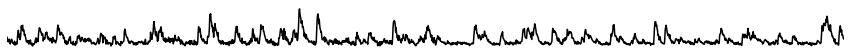

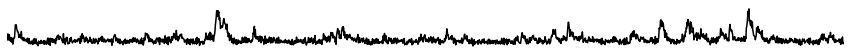

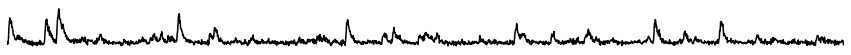

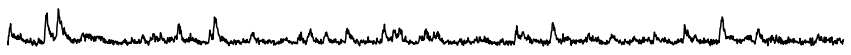

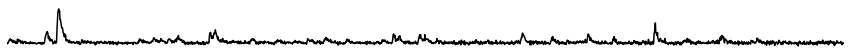

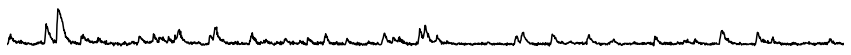

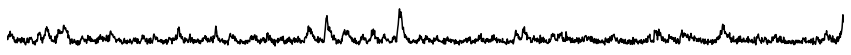

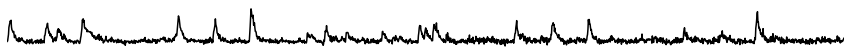

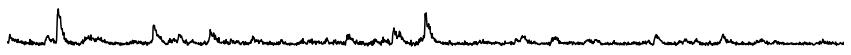

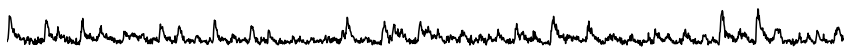

In [3]:
f, s = cilva.core.load_data('data/zf1', convert=True)
N, T = f.shape
for n in range(10):
    plt.figure(figsize=(15, 0.75))
    plt.plot(f[n], color='k')
    plt.xlim([0, T])
    plt.axis('off')
    plt.show()

### Load and compare model fits

In [4]:
alpha, beta, w, b, x, sigma, tau_r, tau_d, gamma, L = cilva.analysis.load_fit(
    'output/cilva_example_L_3_num_iters_40_iters_per_altern_40_gamma_1.00_tau_r_2.62_tau_d_5.31_imrate_2.1646/',
    'train')

kernel = cilva.core.calcium_kernel(tau_r, tau_d, T)
f_hat = cilva.analysis.reconstruction(alpha, beta, w, b, x, kernel, s)
corr_coefs = np.array([np.corrcoef(f[n], f_hat[n])[0, 1] for n in range(N)])
inds = np.argsort(corr_coefs)[::-1]

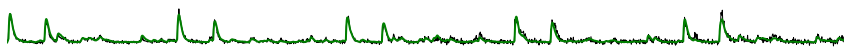

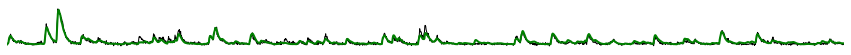

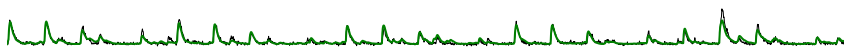

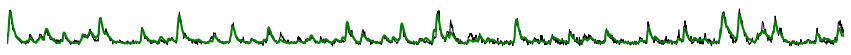

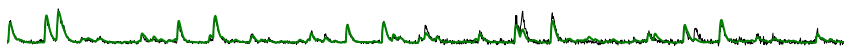

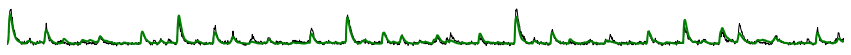

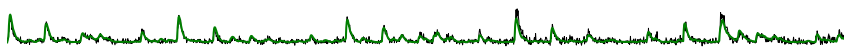

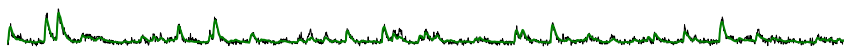

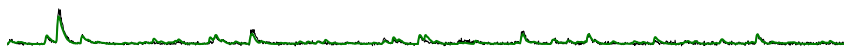

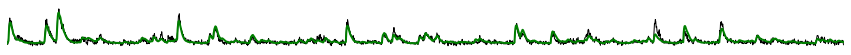

In [5]:
for n in range(10):
    plt.figure(figsize=(15, 0.75))
    plt.plot(f[inds[n]], color='k', linewidth=1)
    plt.plot(f_hat[inds[n]], color='g', linewidth=2)
    plt.axis('off')
    plt.xlim([0, T])
    plt.show()

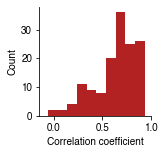

In [6]:
plt.figure(figsize=(2, 2))
plt.hist(corr_coefs, color='firebrick')
plt.xlim([-0.15, 1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
plt.show()

In [7]:
np.mean(corr_coefs)

0.631969312780442

### Decouple evoked and (low dimensional) spontaneous components

In [8]:
f_evoked, f_spont = cilva.analysis.decouple_traces(alpha, beta, w, b, x, kernel, s)

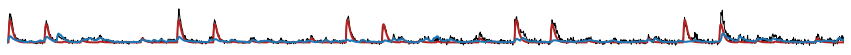

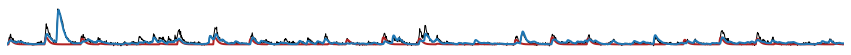

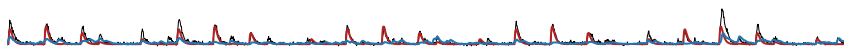

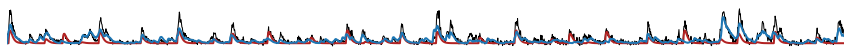

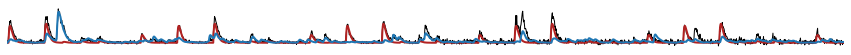

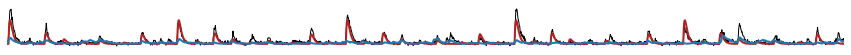

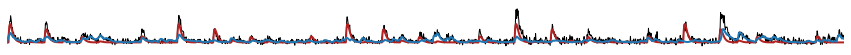

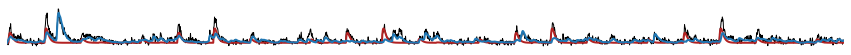

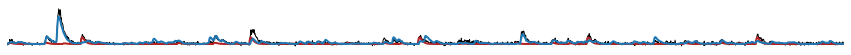

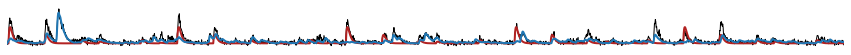

In [9]:
for n in range(10):
    plt.figure(figsize=(15, 0.75))
    plt.plot(f[inds[n]], color='k', linewidth=1)
    plt.plot(f_evoked[inds[n]], color='firebrick', linewidth=2)
    plt.plot(f_spont[inds[n]], color='C0', linewidth=2)
    plt.axis('off')
    plt.xlim([0, T])
    plt.show()

### Model components

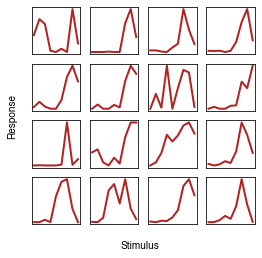

In [10]:
'''

    Tuning curves

'''

kmax = np.max(kernel)
tuning_curves = (kmax * alpha[:, None] * w)[:, 2:] # First two stimuli not presented

fig, axes = plt.subplots(figsize=(4, 4), sharex=True, sharey=False, ncols=4, nrows=4)
for n in range(16):
    plt.subplot(4, 4, n + 1)
    plt.plot(tuning_curves[n, :], color='firebrick', linewidth=2)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xticks([])
    plt.yticks([])
fig.text(0.5, 0.04, 'Stimulus', ha='center')
fig.text(0.04, 0.5, 'Response', va='center', rotation='vertical')
plt.show()

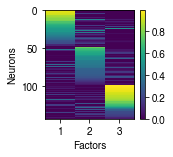

In [11]:
'''
    
    Factor loading matrix

'''

# Sort neurons to maximise visual modularity
b_order = []
ams = np.argmax(b, 1)
L = L.astype(int)
for l in range(L):
    nrns = np.where(ams == l)[0]
    b_order.append(nrns[np.argsort(b[nrns, l])[::-1]])
b_order = np.concatenate(b_order)
b = b[b_order, :]

plt.figure(figsize=(2, 2))
plt.imshow(b, aspect='auto')
plt.colorbar()
plt.xticks(range(L))
plt.gca().set_xticklabels(range(1, L + 1))
plt.xlabel('Factors')
plt.ylabel('Neurons')
plt.show()

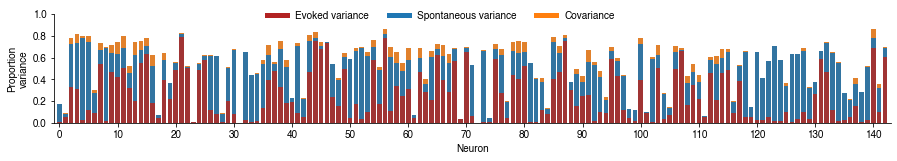

In [12]:
'''

    Decomposition of variance

'''

var_total = np.var(f_hat, 1)
var_evoked = np.var(f_evoked, 1)
var_spont = np.var(f_spont, 1)
var_cov = (var_total - var_spont - var_evoked)/2
var_f = np.var(f, 1) - sigma**2 # Correction for imaging noise variance

plt.figure(figsize=(15, 2))
plt.plot([], [], color='firebrick', linewidth=5)
plt.plot([], [], color='C0', linewidth=5)
plt.plot([], [], color='C1', linewidth=5)

plt.legend(['Evoked variance', 'Spontaneous variance', 'Covariance'], frameon=False, ncol=3, loc=(0.25, 0.9))

sns.barplot(np.arange(N), var_evoked/var_f, color='firebrick', linewidth=0)
sns.barplot(np.arange(N), var_spont/var_f, bottom = var_evoked/var_f, linewidth=0, color='C0')
sns.barplot(np.arange(N), np.abs(var_cov)/var_f, bottom = (var_evoked + var_spont)/var_f, linewidth=0, color='C1')

plt.xlabel('Neuron')
plt.ylabel('Proportion\nvariance')
plt.xticks(np.arange(0, N, 10))
plt.gca().set_xticklabels(np.arange(0, N, 10))
plt.xlim([-1, N])
plt.ylim([0, 1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()